In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import io
import glob
from PIL import Image
from datetime import datetime
from skimage.exposure import equalize_hist
from scipy.interpolate import interp1d

In [2]:
# Import files from each position
filenames1 = glob.glob('d700/glass*detv0*.tif')
filenames2 = glob.glob('d700/glass*detv15*.tif')
filenames3 = glob.glob('d700/glass*detv30*.tif')

#filenames1 = glob.glob('Pilatus gain/Graphite/*pos_1*.tif')
#filenames2 = glob.glob('Pilatus gain/Graphite/*pos_2*.tif')
#filenames2 = glob.glob('Pilatus gain/Graphite/*pos_2*.tif')

# Import 2-theta maps
#t1 = np.load('maps/*detv0*_2thetamap.tif')
#t2 = np.load('maps/*detv15*_2thetamap.tif')
#t3 = np.load('maps/*detv30*_2thetamap.tif')
t1 = io.imread('maps/*d700*detv0*_2thetamap.tif')
t2 = io.imread('maps/*d700*detv15*_2thetamap.tif')
t3 = io.imread('maps/*d700*detv30*_2thetamap.tif')
# Import polarization scaling map
p1 = io.imread('maps/*d700*detv0*_polscalemap.tif')
p2 = io.imread('maps/*d700*detv15*_polscalemap.tif')
p3 = io.imread('maps/*d700*detv30*_polscalemap.tif')


def read_files(filenames):
    data = []
    for i in range(0, len(filenames)):
        data.append(io.imread(filenames[i]))
    data = np.asarray(data)
    
    return data

# Import data at each position
data1 = read_files(filenames1)
data2 = read_files(filenames2)
data3 = read_files(filenames3)

# Set all values less -1 to -1
# -2 seems to indicate dead pixels on pilatus?
data1[data1<=-1] = -1
data2[data2<=-1] = -1
data3[data3<=-1] = -1

# Average all images taken at each position
a1 = np.sum(data1, axis = 0)/data1.shape[0]
a2 = np.sum(data2, axis = 0)/data2.shape[0]
a3 = np.sum(data3, axis = 0)/data2.shape[0]

# Clear data arrays
del data1; del data2; del data3

# Return a mask with 1 at measured value, NaN at dead pixels or intermodule gaps
def nan_mask(data):
    mask = np.copy(data)
    mask[mask>=0] = 1
    mask[mask<0] = np.nan
    return mask

# Set non-measured pixels to NaN
n1 = np.multiply(a1, nan_mask(a1))
n2 = np.multiply(a2, nan_mask(a2))
n3 = np.multiply(a3, nan_mask(a3))
# Apply polarization scaling correction
n1 = np.divide(n1, p1)
n2 = np.divide(n2, p2)
n3 = np.divide(n3, p3)

In [3]:
# Bin 2-theta map
# Input (2-theta map, total number of bins)
# Return bin, map of bin index
def bin_map(tmap, nbins):
    bins = np.linspace(np.min(tmap), np.max(tmap), num = nbins)
    binned = np.digitize(tmap, bins) -1 # Digitize index starts at 1
    return bins, binned

# Unwrap diffraction image
# Takes input of diffraction pattern, 2-theta map, and number of bins
# Defaults to 800 bins if no input is provided
# Return bins and unwrapped radial array
def unwrap_image(data, datamap, bins = 800):
    bins, binmap = bin_map(datamap, bins) # Bin input 2-theta map (bins, map of bins)
    values = np.array((binmap.ravel(), data.ravel())) # Values from diffraction pattern (bin, values)
    rind = np.unique(values[0]) # Unique indicies 
    
    avals = [] # Empty array 
    lengths = np.zeros(len(rind)) # Total count of values at each 2-theta
    for i in range (0, len(rind)):
        pos = np.where(values[0] == rind[i])
        vals = np.ndarray.flatten(values[:, pos][1])
        lengths[i] = len(vals)
        avals.append(vals)
   
    radial_array = np.zeros((len(avals), int(np.max(lengths)))) # Output array for unwrapped values
    for i in range (0, len(avals)):
        nan_array = np.empty( int( np.max(lengths) - len(avals[i]) ) ) # Initialize empty array for values not in measurement
        nan_array[:] = np.nan # Set all values in array to NaN
        radial_array[i] = np.concatenate( (avals[i], nan_array) )
    # Return 2-theta bins and unwrapped array
    return bins, radial_array

# Bootstrap resample unwrapped radial array along horizontal
# Returned array has same number of samples along horizontal
# Subsamples are 10 for no particular reason
def bootstrap_resample(rad_array):
    out_arr = np.empty(rad_array.shape) # Initialize output array
    for i in range (rad_array.shape[0]): # Loop over horizontal rows
        data = np.copy(rad_array[i]) # Copy current row
        data = data[~np.isnan(data)] # Remove nans
        resamples = np.random.choice(data, size = (10, rad_array.shape[1]), replace = True) # 10 x [input horizontal] random samples with replacement 
        medians = np.nanmedian(resamples, axis = 0) # Take median across axis 0 to return [input horizontal] medians
        out_arr[i] = medians # Put medians in output array
    return out_arr

# Interpolate the bootstrapped data map and return interpolating function
# Pick range of 2-theta values at high 2-theta to use for extrapolation at high 2-theta
# Pass bootstrapped map, bins from unwrapping function ( unwrap_image() ), min 2theta, and max 2theta
# Extrapolate to twice the input 2-theta value
def interpolate_bstrap(bmap, bins, min_val, max_val):
    median_vals = np.nanmedian(bmap, axis = 1) # Take median of bootstrapped array
    f = interp1d(bins, median_vals, kind = 'slinear', fill_value = 'extrapolate') # Interpolate data using order 1 splines
    x_extrap = np.linspace(min_val, max_val, 100) # Get x-values for extrapolation at high 2-theta
    y_extrap = f(x_extrap) # Get y-values for extrapolation from previous interpolation
    f_extrap = interp1d(x_extrap, y_extrap, kind = 'slinear', fill_value = 'extrapolate') # Function for extrapolating high 2-theta using order 1 splines
    
    # Calculate new values including extrapolated region
    # Use 5000 points for interpolation for no particular reason
    x_new = np.linspace(bins[0], bins[-1]*2, 5000) # X values
    y_new = [] # Array for y values
    for i in range (0, len(x_new)):
        if x_new[i] <= min_val:
            y_new.append(f(x_new[i])) # Below cutoff use intepolation of data
        if x_new[i] > min_val:
            y_new.append(f_extrap(x_new[i])) # Above cutoff use extrapolation from cutoff range specified
    y_new = np.array(y_new)
    # Calculate interpolating function for new y-values that include extrapolation at high 2-theta
    # Use order 1 splines for interpolation
    f_out = interp1d(x_new,y_new, kind = 'slinear', fill_value = 'extrapolate')
    return f_out
# Interpolate the unwrapped data map and return interpolating function
# Pick range of 2-theta values at high 2-theta to use for extrapolation at high 2-theta
# Pass bootstrapped map, bins from unwrapping function ( unwrap_image() ), min 2theta, and max 2theta
# Extrapolate to twice the input 2-theta value
def interpolate_uwrap(umap, bins, min_val, max_val):
    median_vals = np.nanmedian(umap, axis = 1) # Take median of bootstrapped array
    f = interp1d(bins, median_vals, kind = 'slinear', fill_value = 'extrapolate') # Interpolate data using order 1 splines
    x_extrap = np.linspace(min_val, max_val, 100) # Get x-values for extrapolation at high 2-theta
    y_extrap = f(x_extrap) # Get y-values for extrapolation from previous interpolation
    f_extrap = interp1d(x_extrap, y_extrap, kind = 'slinear', fill_value = 'extrapolate') # Function for extrapolating high 2-theta using order 1 splines
    
    # Calculate new values including extrapolated region
    # Use 5000 points for interpolation for no particular reason
    x_new = np.linspace(bins[0], bins[-1]*2, 5000) # X values
    y_new = [] # Array for y values
    for i in range (0, len(x_new)):
        if x_new[i] <= min_val:
            y_new.append(f(x_new[i])) # Below cutoff use intepolation of data
        if x_new[i] > min_val:
            y_new.append(f_extrap(x_new[i])) # Above cutoff use extrapolation from cutoff range specified
    y_new = np.array(y_new)
    # Calculate interpolating function for new y-values that include extrapolation at high 2-theta
    # Use order 1 splines for interpolation
    f_out = interp1d(x_new,y_new, kind = 'slinear', fill_value = 'extrapolate')
    return f_out

# Calculate a gain map from three positions
# Input set of average images at three positions (pos1, pos2, pos3) and corresponding 2-theta maps (tmap1, tmap2, tmap3)
# Provide min/max for 2-theta region to use for extrapolation for high 2-theta (e_min, e_max). This provides an estimated gain at high 2-theta
# Select position (1, 2, 3) to return gain map for, returns gain map for position 1 by default
# Specify number of bins to use for radial average, defaults to 800
# Gain map at edges where information is estimated by extrapolation is probably not super reliable
# Gain map inside beamstop is also not correct
def gain_map(pos1, pos2, pos3, tmap1, tmap2, tmap3, e_min, e_max, position = 1, bins = 800):
    # Unwrap images to generate maps of 2-theta vs number of counts
    bins1, map1 = unwrap_image(pos1, tmap1, bins)
    bins2, map2 = unwrap_image(pos2, tmap2, bins)
    bins3, map3 = unwrap_image(pos3, tmap3, bins)
    ## Bootstrap resample unwrapped maps
    ## Improvement appears marginal, not clear if this actually necessary but it adds only ~5s per position
    #bmap1 = bootstrap_resample(map1)
    #bmap2 = bootstrap_resample(map2)
    #bmap3 = bootstrap_resample(map3)
    ## Interpolate bootstrapped maps 
    #ifun1 = interpolate_bstrap(bmap1, bins1, e_min, e_max)
    #ifun2 = interpolate_bstrap(bmap2, bins2, e_min, e_max)
    #ifun3 = interpolate_bstrap(bmap3, bins3, e_min, e_max)
    ifun1 = interpolate_uwrap(map1, bins1, e_min, e_max)
    ifun2 = interpolate_uwrap(map2, bins2, e_min, e_max)
    ifun3 = interpolate_uwrap(map3, bins3, e_min, e_max)
    
    #test = (ifun1(tmap1)+ifun2(tmap1)+ifun3(tmap1))/3
    #gmap = a1/test
    if position == 1:
        signal = (ifun1(tmap1)+ifun2(tmap1)+ifun3(tmap1))/3 # Generate 3 estimated signals at position and then average
        gmap = pos1/signal
    if position == 2:
        signal = (ifun1(tmap2)+ifun2(tmap2)+ifun3(tmap2))/3 # Generate 3 estimated signals at position and then average
        gmap = pos2/signal
    if position == 3:
        signal = (ifun1(tmap3)+ifun2(tmap3)+ifun3(tmap3))/3 # Generate 3 estimated signals at position and then average
        gmap = pos3/signal
    
    return gmap # Return gainmap

Text(0, 0.5, 'Counts')

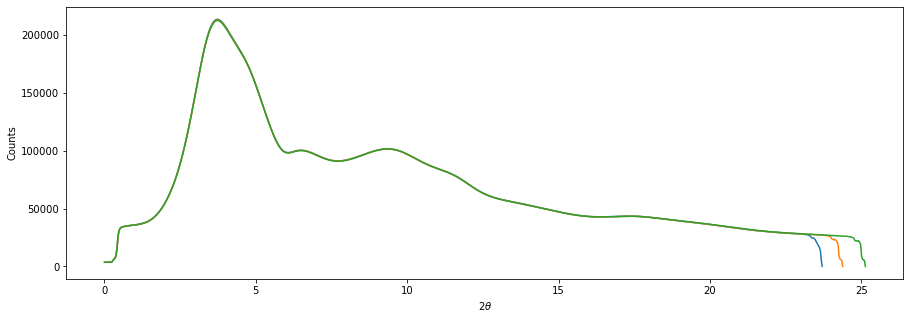

In [4]:
tx1, ty1 = unwrap_image(n1, t1, bins = 800)
tx2, ty2 = unwrap_image(n2, t2, bins = 800)
tx3, ty3 = unwrap_image(n3, t3, bins = 800)
y1 = np.nanmedian(ty1, axis = 1)
y2 = np.nanmedian(ty2, axis = 1)
y3 = np.nanmedian(ty3, axis = 1)

plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(tx1, y1)
plt.plot(tx2, y2)
plt.plot(tx3, y3)
plt.xlabel('2$\\theta$')
plt.ylabel('Counts')

# Use 21 -> 22 for extrapolation bounds

In [10]:
start, stop = 21, 22 # Extrapolation bounds
map1 = gain_map(n1, n2, n3, t1, t2, t3, 21, 22, 1, 3000)
map2 = gain_map(n1, n2, n3, t1, t2, t3, 21, 22, 2, 3000)
map3 = gain_map(n1, n2, n3, t1, t2, t3, 21, 22, 3, 3000)

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.subplot(2, 3, 1)
plt.imshow(n1, vmax = 110000)
plt.title('Position 1')
plt.subplot(2, 3, 2)
plt.imshow(n2, vmax = 110000)
plt.title('Position 2')
plt.subplot(2, 3, 3)
plt.imshow(n3, vmax = 110000)
plt.title('Position 3')

plt.subplot(2, 3, 4)
plt.imshow(map1, vmin = 0.85, vmax = 1.15)
plt.subplot(2, 3, 5)
plt.imshow(map2, vmin = 0.85, vmax = 1.15)
plt.subplot(2, 3, 6)
plt.imshow(map3, vmin = 0.85, vmax = 1.15)

In [ ]:
# Export gain map calculated for first position (translation = 0)
# Convert gain map to GSAS II format, remove nans and resulting inf values from divide by zeros
nmap = np.nan_to_num(1/map1)
nmap[nmap>10**10] = 0
nmap[nmap<-10**10] = 0
# Export map as 32 bit tif
im = Image.fromarray(np.float32(nmap), mode='F') # float32
im.save('d700_gain_map_'+datetime.today().strftime('%Y-%m-%d')+'.tif', 'TIFF')